# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [62]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    transform = transforms.Compose([transforms.Resize(image_size), 
                                    transforms.CenterCrop(image_size),
                                   transforms.ToTensor()])
    # TODO: Implement function and return a dataloader
    im_data = datasets.ImageFolder(data_dir, transform)
    im_loader = torch.utils.data.DataLoader(im_data, batch_size=batch_size, shuffle=True)
    return im_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 128
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

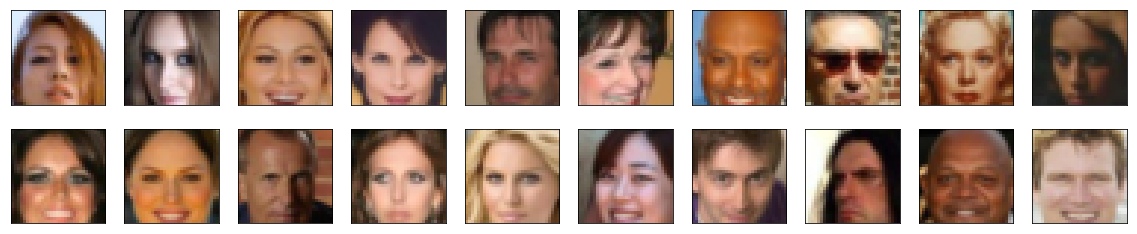

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    out = x * (feature_range[1] - feature_range[0]) + feature_range[0]
    return out


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9765)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True, k_relu=0):
    layers = []
    
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    if k_relu > 0:
        layers.append(nn.LeakyReLU(k_relu))
    
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        #32-16-8-4-2
        # complete init function
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False, k_relu=0.2)
        self.conv2 = conv(conv_dim, conv_dim*2, 4, k_relu=0.2)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4, k_relu=0.2)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4, k_relu=0.2)
        
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)
        #or self.fc = nn.Linear(conv_dim*8*2*2, 1) and forwrard x-> flatten

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        x = x.view(-1, 1)
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True, use_relu=True):
    layers = []
    
    conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    if use_relu:
        layers.append(nn.ReLU())
    
    return nn.Sequential(*layers)

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)
        
        self.deconv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.deconv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv3 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv4 = deconv(conv_dim, 3, 4, batch_norm=False, use_relu=False)
        
        self.tanh = nn.Tanh()        
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*8, 2, 2)
        
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        
        x = self.tanh(x)
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
        
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [42]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 512

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv5): Sequential(
    (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [43]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [44]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size) 
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss


def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) 
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [45]:
import torch.optim as optim

lr = 0.0002
beta1=0.5
beta2=0.999

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [46]:
def create_z(batch_size, z_size):
    z = np.random.uniform(-1, 1, size=(batch_size, z_size))
    z = torch.from_numpy(z).float()
            
    if train_on_gpu:
        z = z.cuda()
        
    return z

In [20]:
import time
from workspace_utils import keep_awake
from workspace_utils import active_session

In [83]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    
    
    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):
                        
            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            if train_on_gpu:
                real_images = real_images.cuda()

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()            
            out_real = D(real_images)
            d_real_loss = real_loss(out_real)

            z = create_z(batch_size, z_size)
            fake_images = G(z)
            out_fake = D(fake_images)
            d_fake_loss = fake_loss(out_fake)
            d_loss = d_real_loss + d_fake_loss
            
            d_loss.backward()
            d_optimizer.step()
            
            # 2. Train the generator with an adversarial loss
            #repeat = True
            #iii = 0
            #while repeat:
            #    iii+=1
            g_optimizer.zero_grad()
            z = create_z(batch_size, z_size)
            fake_images = G(z)

            out_fake_g = D(fake_images)            
            g_loss = real_loss(out_fake_g)
            g_loss.backward()
            g_optimizer.step()
            #    if batch_i % print_every == 0:
            #        losses.append((d_loss.item(), g_loss.item()))
            #    if iii > 5:
            #        print(iii)
            #    if g_loss < d_loss * 1.5:
            #        repeat = False
            
            
                
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
            
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [84]:
# set number of epochs 
n_epochs = 48 

with active_session():
    """
    DON'T MODIFY ANYTHING IN THIS CELL
    """
    # call training function
    losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   48] | d_loss: 1.3720 | g_loss: 0.9075
Epoch [    1/   48] | d_loss: 0.2181 | g_loss: 3.5231
Epoch [    1/   48] | d_loss: 0.0977 | g_loss: 4.3122
Epoch [    1/   48] | d_loss: 0.0323 | g_loss: 4.9110
Epoch [    1/   48] | d_loss: 0.2908 | g_loss: 3.4193
Epoch [    1/   48] | d_loss: 0.3435 | g_loss: 3.3635
Epoch [    1/   48] | d_loss: 0.1311 | g_loss: 2.7067
Epoch [    1/   48] | d_loss: 0.4665 | g_loss: 4.2824
Epoch [    1/   48] | d_loss: 0.3707 | g_loss: 2.7301
Epoch [    1/   48] | d_loss: 0.4217 | g_loss: 2.7876
Epoch [    1/   48] | d_loss: 0.7111 | g_loss: 2.1848
Epoch [    1/   48] | d_loss: 0.5392 | g_loss: 3.0000
Epoch [    1/   48] | d_loss: 0.6385 | g_loss: 2.8541
Epoch [    1/   48] | d_loss: 0.6818 | g_loss: 1.8848
Epoch [    1/   48] | d_loss: 1.9499 | g_loss: 3.3974
Epoch [    2/   48] | d_loss: 0.4980 | g_loss: 2.9196
Epoch [    2/   48] | d_loss: 0.9814 | g_loss: 1.8087
Epoch [    2/   48] | d_loss: 0.6326 | g_loss: 2.5579
Epoch [    2/   48] | d_loss

Epoch [   11/   48] | d_loss: 0.7260 | g_loss: 1.6188
Epoch [   11/   48] | d_loss: 1.2809 | g_loss: 0.7764
Epoch [   11/   48] | d_loss: 0.6799 | g_loss: 2.0852
Epoch [   11/   48] | d_loss: 0.6959 | g_loss: 1.7172
Epoch [   11/   48] | d_loss: 0.6534 | g_loss: 3.3326
Epoch [   11/   48] | d_loss: 0.6475 | g_loss: 1.6633
Epoch [   11/   48] | d_loss: 0.4914 | g_loss: 1.9953
Epoch [   11/   48] | d_loss: 0.6767 | g_loss: 2.1877
Epoch [   11/   48] | d_loss: 0.5303 | g_loss: 1.5935
Epoch [   11/   48] | d_loss: 0.9869 | g_loss: 1.0523
Epoch [   11/   48] | d_loss: 0.6039 | g_loss: 2.4355
Epoch [   11/   48] | d_loss: 0.5644 | g_loss: 2.2872
Epoch [   11/   48] | d_loss: 0.8176 | g_loss: 2.8019
Epoch [   12/   48] | d_loss: 0.6034 | g_loss: 2.3500
Epoch [   12/   48] | d_loss: 0.5651 | g_loss: 1.7983
Epoch [   12/   48] | d_loss: 0.6233 | g_loss: 1.5480
Epoch [   12/   48] | d_loss: 0.5275 | g_loss: 2.9139
Epoch [   12/   48] | d_loss: 0.6301 | g_loss: 1.6610
Epoch [   12/   48] | d_loss

Epoch [   21/   48] | d_loss: 0.6692 | g_loss: 4.3146
Epoch [   21/   48] | d_loss: 0.2792 | g_loss: 2.8611
Epoch [   21/   48] | d_loss: 0.3568 | g_loss: 2.0094
Epoch [   21/   48] | d_loss: 0.4277 | g_loss: 2.6790
Epoch [   21/   48] | d_loss: 0.6172 | g_loss: 3.8692
Epoch [   21/   48] | d_loss: 0.6292 | g_loss: 4.1291
Epoch [   21/   48] | d_loss: 0.3486 | g_loss: 3.2421
Epoch [   21/   48] | d_loss: 0.3677 | g_loss: 2.3995
Epoch [   21/   48] | d_loss: 0.5827 | g_loss: 2.0614
Epoch [   21/   48] | d_loss: 0.3142 | g_loss: 3.3764
Epoch [   22/   48] | d_loss: 0.7557 | g_loss: 5.2038
Epoch [   22/   48] | d_loss: 0.2738 | g_loss: 3.0837
Epoch [   22/   48] | d_loss: 0.2299 | g_loss: 3.0234
Epoch [   22/   48] | d_loss: 0.6051 | g_loss: 1.8132
Epoch [   22/   48] | d_loss: 0.4452 | g_loss: 4.7013
Epoch [   22/   48] | d_loss: 0.3265 | g_loss: 3.0972
Epoch [   22/   48] | d_loss: 0.3080 | g_loss: 2.1372
Epoch [   22/   48] | d_loss: 0.3852 | g_loss: 2.8169
Epoch [   22/   48] | d_loss

Epoch [   31/   48] | d_loss: 0.1896 | g_loss: 4.1703
Epoch [   31/   48] | d_loss: 0.1933 | g_loss: 3.5080
Epoch [   31/   48] | d_loss: 0.1467 | g_loss: 4.6497
Epoch [   31/   48] | d_loss: 0.3187 | g_loss: 4.7514
Epoch [   31/   48] | d_loss: 0.5553 | g_loss: 5.0154
Epoch [   31/   48] | d_loss: 0.1967 | g_loss: 3.9837
Epoch [   31/   48] | d_loss: 0.4814 | g_loss: 4.5507
Epoch [   31/   48] | d_loss: 0.1671 | g_loss: 4.6461
Epoch [   32/   48] | d_loss: 0.3601 | g_loss: 4.5690
Epoch [   32/   48] | d_loss: 0.1712 | g_loss: 3.3893
Epoch [   32/   48] | d_loss: 0.1615 | g_loss: 4.3530
Epoch [   32/   48] | d_loss: 0.1332 | g_loss: 3.7233
Epoch [   32/   48] | d_loss: 0.4953 | g_loss: 3.5183
Epoch [   32/   48] | d_loss: 0.2534 | g_loss: 3.6480
Epoch [   32/   48] | d_loss: 0.1795 | g_loss: 3.4775
Epoch [   32/   48] | d_loss: 0.1710 | g_loss: 5.0411
Epoch [   32/   48] | d_loss: 0.3106 | g_loss: 3.7476
Epoch [   32/   48] | d_loss: 0.4904 | g_loss: 2.0617
Epoch [   32/   48] | d_loss

Epoch [   41/   48] | d_loss: 0.1354 | g_loss: 5.2766
Epoch [   41/   48] | d_loss: 0.1116 | g_loss: 3.8104
Epoch [   41/   48] | d_loss: 0.1392 | g_loss: 4.0965
Epoch [   41/   48] | d_loss: 0.4508 | g_loss: 5.1852
Epoch [   41/   48] | d_loss: 0.2376 | g_loss: 2.8147
Epoch [   41/   48] | d_loss: 0.0878 | g_loss: 5.4442
Epoch [   42/   48] | d_loss: 0.1612 | g_loss: 4.4612
Epoch [   42/   48] | d_loss: 0.0654 | g_loss: 3.2456
Epoch [   42/   48] | d_loss: 0.1320 | g_loss: 3.2850
Epoch [   42/   48] | d_loss: 0.2143 | g_loss: 5.5592
Epoch [   42/   48] | d_loss: 1.0936 | g_loss: 1.1677
Epoch [   42/   48] | d_loss: 0.1256 | g_loss: 2.4838
Epoch [   42/   48] | d_loss: 0.0998 | g_loss: 5.1935
Epoch [   42/   48] | d_loss: 0.1343 | g_loss: 4.6319
Epoch [   42/   48] | d_loss: 0.2121 | g_loss: 4.2358
Epoch [   42/   48] | d_loss: 0.1282 | g_loss: 2.8086
Epoch [   42/   48] | d_loss: 0.2492 | g_loss: 3.2238
Epoch [   42/   48] | d_loss: 0.1264 | g_loss: 5.0773
Epoch [   42/   48] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

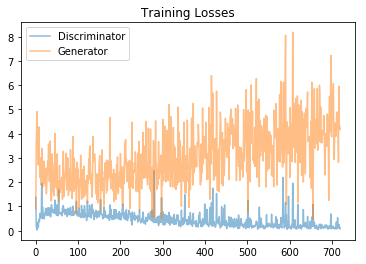

In [87]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

Unfortunately, the file "train_samples.pkl" was empty. By logging it is clear that in recent erases the generator has become worse at learning. 
In the next training session, I will add that the training speed of the generator will change dynamically.

In [47]:
lr = 0.0002
beta1=0.5
beta2=0.999


d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), 0.0009, [beta1, beta2])

g_scheduler = optim.lr_scheduler.ReduceLROnPlateau(g_optimizer, 'min', patience=9, factor=0.5, verbose=True)

In [48]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    
    
    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):
                        
            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            if train_on_gpu:
                real_images = real_images.cuda()

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()            
            out_real = D(real_images)
            d_real_loss = real_loss(out_real)

            z = create_z(batch_size, z_size)
            fake_images = G(z)
            out_fake = D(fake_images)
            d_fake_loss = fake_loss(out_fake)
            d_loss = d_real_loss + d_fake_loss
            
            d_loss.backward()
            d_optimizer.step()
            
            # 2. Train the generator with an adversarial loss
            #repeat = True
            #iii = 0
            #while repeat:
            #    iii+=1
            g_optimizer.zero_grad()
            z = create_z(batch_size, z_size)
            fake_images = G(z)

            out_fake_g = D(fake_images)            
            g_loss = real_loss(out_fake_g)
            g_loss.backward()
            g_optimizer.step()
            #    if batch_i % print_every == 0:
            #        losses.append((d_loss.item(), g_loss.item()))
            #    if iii > 5:
            #        print(iii)
            #    if g_loss < d_loss * 1.5:
            #        repeat = False
            
            
                
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))

        
        g_scheduler.step(g_loss) #To dynamically change learning rate            
        
        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
        f.close() # I added this line 
    
    # finally return losses
    return losses

In [49]:
# set number of epochs 
n_epochs = 36 

with active_session():
    """
    DON'T MODIFY ANYTHING IN THIS CELL
    """
    # call training function
    losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   36] | d_loss: 1.3649 | g_loss: 0.9919
Epoch [    1/   36] | d_loss: 1.1530 | g_loss: 1.5370
Epoch [    1/   36] | d_loss: 1.2369 | g_loss: 1.2565
Epoch [    1/   36] | d_loss: 1.2922 | g_loss: 1.0583
Epoch [    1/   36] | d_loss: 1.4365 | g_loss: 1.2105
Epoch [    1/   36] | d_loss: 1.3775 | g_loss: 0.9898
Epoch [    1/   36] | d_loss: 1.1788 | g_loss: 1.1099
Epoch [    1/   36] | d_loss: 1.2976 | g_loss: 1.3598
Epoch [    1/   36] | d_loss: 1.2821 | g_loss: 1.2263
Epoch [    1/   36] | d_loss: 1.4936 | g_loss: 1.5291
Epoch [    1/   36] | d_loss: 1.1437 | g_loss: 1.3999
Epoch [    1/   36] | d_loss: 0.9434 | g_loss: 1.7551
Epoch [    1/   36] | d_loss: 1.1686 | g_loss: 1.4836
Epoch [    1/   36] | d_loss: 1.0389 | g_loss: 1.7624
Epoch [    1/   36] | d_loss: 1.0217 | g_loss: 1.6465
Epoch [    2/   36] | d_loss: 1.1836 | g_loss: 1.5058
Epoch [    2/   36] | d_loss: 1.1106 | g_loss: 1.4836
Epoch [    2/   36] | d_loss: 1.0324 | g_loss: 1.5974
Epoch [    2/   36] | d_loss

Epoch [   11/   36] | d_loss: 0.7154 | g_loss: 1.6072
Epoch [   11/   36] | d_loss: 0.8863 | g_loss: 1.6183
Epoch [   11/   36] | d_loss: 0.6188 | g_loss: 1.7894
Epoch [   11/   36] | d_loss: 0.5899 | g_loss: 2.0737
Epoch [   11/   36] | d_loss: 0.7658 | g_loss: 1.6694
Epoch [   11/   36] | d_loss: 0.9868 | g_loss: 0.8575
Epoch [   11/   36] | d_loss: 0.8238 | g_loss: 2.5502
Epoch [   11/   36] | d_loss: 0.6357 | g_loss: 1.9611
Epoch [   11/   36] | d_loss: 0.6625 | g_loss: 1.8573
Epoch [   11/   36] | d_loss: 0.9115 | g_loss: 2.5682
Epoch [   11/   36] | d_loss: 0.7785 | g_loss: 1.3398
Epoch [   11/   36] | d_loss: 0.7529 | g_loss: 2.1526
Epoch [   12/   36] | d_loss: 0.6923 | g_loss: 1.8468
Epoch [   12/   36] | d_loss: 0.7189 | g_loss: 1.7761
Epoch [   12/   36] | d_loss: 0.7957 | g_loss: 2.3736
Epoch [   12/   36] | d_loss: 0.6692 | g_loss: 1.6549
Epoch [   12/   36] | d_loss: 0.7516 | g_loss: 1.6760
Epoch [   12/   36] | d_loss: 0.7394 | g_loss: 2.0546
Epoch [   12/   36] | d_loss

Epoch [   21/   36] | d_loss: 0.4518 | g_loss: 3.3509
Epoch [   21/   36] | d_loss: 0.6800 | g_loss: 3.3750
Epoch [   21/   36] | d_loss: 0.5373 | g_loss: 4.3755
Epoch [   21/   36] | d_loss: 1.0812 | g_loss: 4.6668
Epoch [   21/   36] | d_loss: 0.3702 | g_loss: 2.4974
Epoch [   21/   36] | d_loss: 0.6747 | g_loss: 1.2927
Epoch [   21/   36] | d_loss: 0.4247 | g_loss: 1.7097
Epoch [   21/   36] | d_loss: 0.5359 | g_loss: 1.3138
Epoch [   21/   36] | d_loss: 0.3112 | g_loss: 2.8373
Epoch [   21/   36] | d_loss: 0.3269 | g_loss: 2.7688
Epoch [   22/   36] | d_loss: 0.5082 | g_loss: 3.6770
Epoch [   22/   36] | d_loss: 0.3831 | g_loss: 2.8543
Epoch [   22/   36] | d_loss: 0.3048 | g_loss: 2.4391
Epoch [   22/   36] | d_loss: 0.3079 | g_loss: 2.2908
Epoch [   22/   36] | d_loss: 0.3947 | g_loss: 3.4027
Epoch [   22/   36] | d_loss: 2.7377 | g_loss: 0.5570
Epoch [   22/   36] | d_loss: 0.4351 | g_loss: 2.6583
Epoch [   22/   36] | d_loss: 0.7079 | g_loss: 3.8292
Epoch [   22/   36] | d_loss

Epoch [   31/   36] | d_loss: 0.1859 | g_loss: 3.0478
Epoch [   31/   36] | d_loss: 0.1378 | g_loss: 4.1188
Epoch [   31/   36] | d_loss: 0.2129 | g_loss: 2.9743
Epoch [   31/   36] | d_loss: 0.2200 | g_loss: 1.8195
Epoch [   31/   36] | d_loss: 0.1470 | g_loss: 5.1010
Epoch [   31/   36] | d_loss: 0.1606 | g_loss: 3.9446
Epoch [   31/   36] | d_loss: 0.1738 | g_loss: 5.3692
Epoch [   31/   36] | d_loss: 0.1272 | g_loss: 2.9864
Epoch [   31/   36] | d_loss: 0.2286 | g_loss: 3.7227
Epoch [   32/   36] | d_loss: 0.3910 | g_loss: 3.1869
Epoch [   32/   36] | d_loss: 0.1353 | g_loss: 3.0729
Epoch [   32/   36] | d_loss: 0.1940 | g_loss: 2.8322
Epoch [   32/   36] | d_loss: 0.1464 | g_loss: 3.6300
Epoch [   32/   36] | d_loss: 0.1320 | g_loss: 3.6702
Epoch [   32/   36] | d_loss: 4.1840 | g_loss: 5.5666
Epoch [   32/   36] | d_loss: 0.2031 | g_loss: 2.2821
Epoch [   32/   36] | d_loss: 0.1679 | g_loss: 3.9722
Epoch [   32/   36] | d_loss: 0.1766 | g_loss: 4.4483
Epoch [   32/   36] | d_loss

In [53]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [54]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
    f.close()

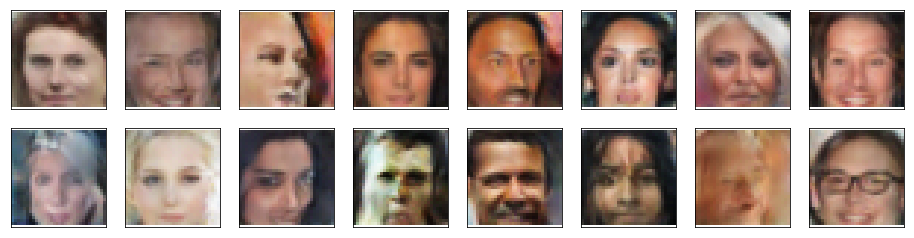

In [55]:
_ = view_samples(-1, samples)

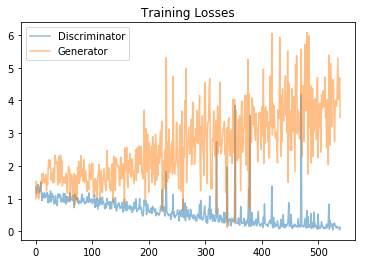

In [56]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)
Three times I started training a neural network with various parameters.
The first time I started with the following parameters: lr=0.0002. optimizers=Adam. z_size=96
The second time I started with the following parameters: lr=0.0002. optimizers=Adam. I use optim.lr_scheduler for dynamically changing learning rate for generator. After the 20th epochs, generator results deteriorate.
The third time I changed only z_size to 512.

Can try adding residual blocks to prevent learning deterioration in the later stages.
or enable the generator to learn more often.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.